<a href="https://colab.research.google.com/github/paolo-peretti/conv/blob/main/capsule.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [339]:
!git clone https://github.com/paolo-peretti/conv
import sys, os
sys.path.append('/content')
os.chdir('/content/conv/')

fatal: destination path 'conv' already exists and is not an empty directory.


In [340]:
import torch

torch.cuda.empty_cache()
device = ("cuda" if torch.cuda.is_available() else "cpu")

from torch.autograd import Variable
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import ToTensor

In [341]:
from capsule_net import CapsNetWithReconstruction, CapsNet, ReconstructionNet, MarginLoss

In [342]:
import matplotlib.pyplot as plt
import numpy as np

# Helper function for inline image display
def imshow_MNIST(img):
    img = img.cpu()
    # img = img / 2 + 0.5     # unnormalize
    # npimg = img.numpy()
    plt.imshow(img.resize(28,28))
    plt.show()

def imshow_CIFAR10(img):
    img = img.cpu()
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [343]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import math

from torch.optim import lr_scheduler
from torch.autograd import Variable


def squash(x):
  lengths2 = x.pow(2).sum(dim=2)
  lengths = lengths2.sqrt()
  x = x * (lengths2 / (1 + lengths2) / lengths).view(x.size(0), x.size(1), 1)
  return x


class AgreementRouting(nn.Module):
  def __init__(self, input_caps, output_caps, n_iterations):
      super(AgreementRouting, self).__init__()
      self.n_iterations = n_iterations
      self.b = nn.Parameter(torch.zeros((input_caps, output_caps)))

  def forward(self, u_predict):
      batch_size, input_caps, output_caps, output_dim = u_predict.size()

      c = F.softmax(self.b)
      s = (c.unsqueeze(2) * u_predict).sum(dim=1)
      v = squash(s)

      if self.n_iterations > 0:
          b_batch = self.b.expand((batch_size, input_caps, output_caps))
          for r in range(self.n_iterations):
              v = v.unsqueeze(1)
              b_batch = b_batch + (u_predict * v).sum(-1)

              c = F.softmax(b_batch.view(-1, output_caps)).view(-1, input_caps, output_caps, 1)
              s = (c * u_predict).sum(dim=1)
              v = squash(s)

      return v


class CapsLayer(nn.Module):
  def __init__(self, input_caps, input_dim, output_caps, output_dim, routing_module):
      super(CapsLayer, self).__init__()
      self.input_dim = input_dim
      self.input_caps = input_caps
      self.output_dim = output_dim
      self.output_caps = output_caps
      self.weights = nn.Parameter(torch.Tensor(input_caps, input_dim, output_caps * output_dim))
      self.routing_module = routing_module
      self.reset_parameters()

  def reset_parameters(self):
      stdv = 1. / math.sqrt(self.input_caps)
      self.weights.data.uniform_(-stdv, stdv)

  def forward(self, caps_output):
      caps_output = caps_output.unsqueeze(2)
      u_predict = caps_output.matmul(self.weights)
      u_predict = u_predict.view(u_predict.size(0), self.input_caps, self.output_caps, self.output_dim)
      v = self.routing_module(u_predict)
      return v


class PrimaryCapsLayer(nn.Module):
  def __init__(self, input_channels, output_caps, output_dim, kernel_size, stride):
      super(PrimaryCapsLayer, self).__init__()
      self.conv = nn.Conv2d(input_channels, output_caps * output_dim, kernel_size=kernel_size, stride=stride)
      self.input_channels = input_channels
      self.output_caps = output_caps
      self.output_dim = output_dim

  def forward(self, input):
      out = self.conv(input)
      N, C, H, W = out.size()
      out = out.view(N, self.output_caps, self.output_dim, H, W)

      # will output N x OUT_CAPS x OUT_DIM
      out = out.permute(0, 1, 3, 4, 2).contiguous()
      out = out.view(out.size(0), -1, out.size(4))
      out = squash(out)
      return out


class CapsNet(nn.Module):
  def __init__(self, routing_iterations, input_channels=1, n_classes=10):
      super(CapsNet, self).__init__()
      self.conv1 = nn.Conv2d(input_channels, 256, kernel_size=9, stride=1)
      self.primaryCaps = PrimaryCapsLayer(256, 32, 8, kernel_size=9, stride=2)  # outputs 6*6
      if input_channels ==1:
        self.num_primaryCaps = 32 * 6 * 6
      elif input_channels == 3:
        self.num_primaryCaps = 32 * 8 * 8

      routing_module = AgreementRouting(self.num_primaryCaps, n_classes, routing_iterations)
      self.digitCaps = CapsLayer(self.num_primaryCaps, 8, n_classes, 16, routing_module)

  def forward(self, input):
      
      x = self.conv1(input)
      
      x = F.relu(x)
  
      x = self.primaryCaps(x)

      x = self.digitCaps(x)
  
      probs = x.pow(2).sum(dim=2).sqrt()
      return x, probs


class ReconstructionNet(nn.Module):
  def __init__(self, n_dim=16, n_classes=10):
      super(ReconstructionNet, self).__init__()
      self.fc1 = nn.Linear(n_dim * n_classes, 512)
      self.fc2 = nn.Linear(512, 1024)
      self.fc3 = nn.Linear(1024, 784)

      self.fc4 = nn.Linear(784, 32*32*3)

      self.n_dim = n_dim
      self.n_classes = n_classes

  def forward(self, x, target):
      mask = Variable(torch.zeros((x.size()[0], self.n_classes)), requires_grad=False)
      if next(self.parameters()).is_cuda:
          mask = mask.cuda()
      mask.scatter_(1, target.view(-1, 1), 1.)
      mask = mask.unsqueeze(2)
      x = x * mask
      x = x.view(-1, self.n_dim * self.n_classes)
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))

      x = F.relu(self.fc3(x))

      x = F.sigmoid(self.fc4(x))
      return x


class CapsNetWithReconstruction(nn.Module):
  def __init__(self, capsnet, reconstruction_net):
      super(CapsNetWithReconstruction, self).__init__()
      self.capsnet = capsnet
      self.reconstruction_net = reconstruction_net

  def forward(self, x, target):
      x, probs = self.capsnet(x)
      reconstruction = self.reconstruction_net(x, target)
      # print(x.shape)
      return reconstruction, probs


class MarginLoss(nn.Module):
  def __init__(self, m_pos, m_neg, lambda_):
      super(MarginLoss, self).__init__()
      self.m_pos = m_pos
      self.m_neg = m_neg
      self.lambda_ = lambda_

  def forward(self, lengths, targets, size_average=True):
      t = torch.zeros(lengths.size()).long()
      if targets.is_cuda:
          t = t.cuda()
      t = t.scatter_(1, targets.data.view(-1, 1), 1)
      targets = Variable(t)
      losses = targets.float() * F.relu(self.m_pos - lengths).pow(2) + \
                self.lambda_ * (1. - targets.float()) * F.relu(lengths - self.m_neg).pow(2)
      return losses.mean() if size_average else losses.sum()

In [344]:
# load model
capsnet = CapsNet(3, 3, 10)
reconstructionnet = ReconstructionNet(16, 10)
model = CapsNetWithReconstruction(capsnet, reconstructionnet)
model.to(device)

CapsNetWithReconstruction(
  (capsnet): CapsNet(
    (conv1): Conv2d(3, 256, kernel_size=(9, 9), stride=(1, 1))
    (primaryCaps): PrimaryCapsLayer(
      (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
    )
    (digitCaps): CapsLayer(
      (routing_module): AgreementRouting()
    )
  )
  (reconstruction_net): ReconstructionNet(
    (fc1): Linear(in_features=160, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=1024, bias=True)
    (fc3): Linear(in_features=1024, out_features=784, bias=True)
    (fc4): Linear(in_features=784, out_features=3072, bias=True)
  )
)

In [345]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

stats = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
transform = transforms.Compose(
    [transforms.RandomCrop(32, padding=4, padding_mode='reflect'), 
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize(*stats,inplace=True)])


# Create datasets for training & validation, download if necessary
# # MNIST

# training_set = MNIST('./data', train=True, transform=transforms.ToTensor(), download=True)
# validation_set = MNIST('./data', train=False, transform=transforms.ToTensor(), download=True)

# # CIFAR10
training_set = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, download=True)
validation_set = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, download=True)


batch_size = 10


# Create data loaders for our datasets; shuffle for training, not for validation
training_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


# Class labels
classes_MNIST = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
classes_CIFAR10 = ('airplane', 'automobile', 'bird', 'cat', 'deer',
        'dog', 'frog', 'horse', 'ship', 'truck')

classes = classes_CIFAR10
# Report split sizes
print('Training set has {} instances'.format(len(training_set)))
print('Validation set has {} instances'.format(len(validation_set)))

Files already downloaded and verified
Files already downloaded and verified
Training set has 50000 instances
Validation set has 10000 instances


In [346]:

import argparse
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
from torch.autograd import Variable

In [347]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, patience=15, min_lr=1e-6)
loss_fn = MarginLoss(0.9, 0.1, 0.5)
reconstruction_alpha=0.0005

In [348]:
def train(epoch):

  model.train()
  for batch_idx, (data, target) in enumerate(training_loader):

    data, target = data.to(device), target.to(device)

    data, target = Variable(data), Variable(target, requires_grad=False)
    
    optimizer.zero_grad()

    # with reconstruction
    output, probs = model(data, target)
    # print(output.shape, data.shape)
    reconstruction_loss = F.mse_loss(output, data.view(-1, 32*32*3)) # , data.view(-1, 784)
    margin_loss = loss_fn(probs, target)
    loss = reconstruction_alpha * reconstruction_loss + margin_loss
    
    # output, probs = model(data)
    # loss = loss_fn(probs, target)

    loss.backward()
    optimizer.step()

    # if batch_idx % 50 == 0:
  print('Train Epoch: {} [{}/{} ({:.0f}%)]\t'.format(epoch, batch_idx * len(data), len(training_loader.dataset),100. * batch_idx / len(training_loader)))
  print('\nLoss: ',loss.item(),'\n')
  print('--------------------------------------------\n')

    

In [349]:
def test():

  with torch.no_grad():
    model.eval()
    test_loss = 0
    correct = 0
    for data, target in validation_loader:
      if True:
        data, target = data.cuda(), target.cuda()
      data, target = Variable(data, volatile=True), Variable(target)

      if True:
        output, probs = model(data, target)
        reconstruction_loss = F.mse_loss(output, data.view(-1, 32*32*3), size_average=False).item() #784
        test_loss += loss_fn(probs, target, size_average=False).item()
        test_loss += reconstruction_alpha * reconstruction_loss
      else:
        output, probs = model(data)
        test_loss += loss_fn(probs, target, size_average=False).item()

      pred = probs.data.max(1, keepdim=True)[1]  # get the index of the max probability
      correct += pred.eq(target.data.view_as(pred)).cpu().sum()

    test_loss /= len(validation_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
              test_loss, correct, len(validation_loader.dataset),
              100. * correct / len(validation_loader.dataset)))
    return test_loss

In [350]:
num_epoch=2
for epoch in range(1, num_epoch + 1):
  train(epoch)
  test_loss = test()
  scheduler.step(test_loss)
  torch.save(model.state_dict(),
                   '{:03d}_model_dict_{}.pth'.format(epoch, 3))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [49990/50000 (100%)]	

Loss:  0.040028803050518036 

--------------------------------------------



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Average loss: 0.8022, Accuracy: 4005/10000 (40%)

Train Epoch: 2 [49990/50000 (100%)]	

Loss:  0.025138942524790764 

--------------------------------------------


Test set: Average loss: 0.7520, Accuracy: 4764/10000 (48%)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:28: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:38: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


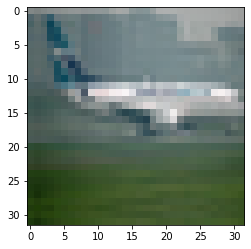

labels:  airplane
predicted:  airplane


In [357]:
import random


index = random.randint(0, 1000 - 1)

for i, data in enumerate(validation_loader):
  # Every data instance is an input + label pair
  if index==i:
    inputs, labels = data
          
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Make predictions for this batch
    outputs, probs = model(inputs, labels)
    
    pred = probs.data.max(1, keepdim=True)[1].cpu()
    
    imshow_CIFAR10(inputs[0])
    
    print('labels: ',classes[labels[0]])
    # CIFAR10
    print('predicted: ',classes[pred[0][0].numpy()])
    break